In [136]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [137]:
# Load the training dataset
train_df = pd.read_csv('Titanic_train.csv')
test_df = pd.read_csv('Titanic_test.csv')

In [138]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [139]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


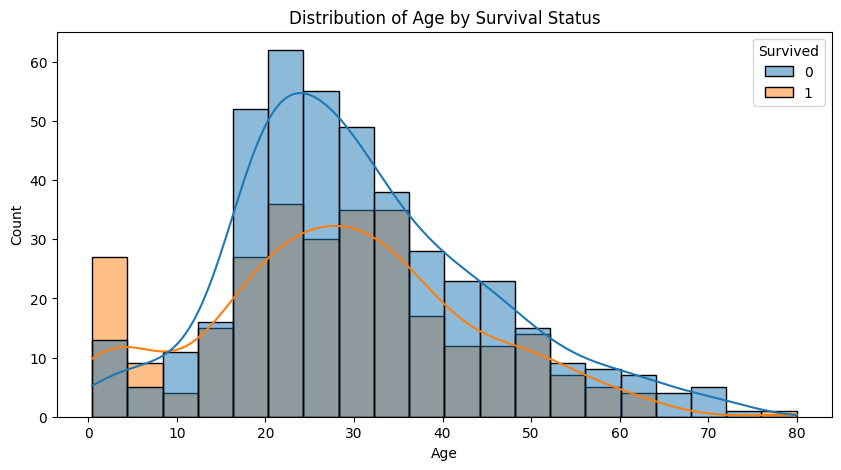

In [140]:
# Visualizations [cite: 5]
# Histogram of Age
plt.figure(figsize=(10, 5))
sns.histplot(data=train_df, x='Age', hue='Survived', kde=True)
plt.title('Distribution of Age by Survival Status')
plt.show()

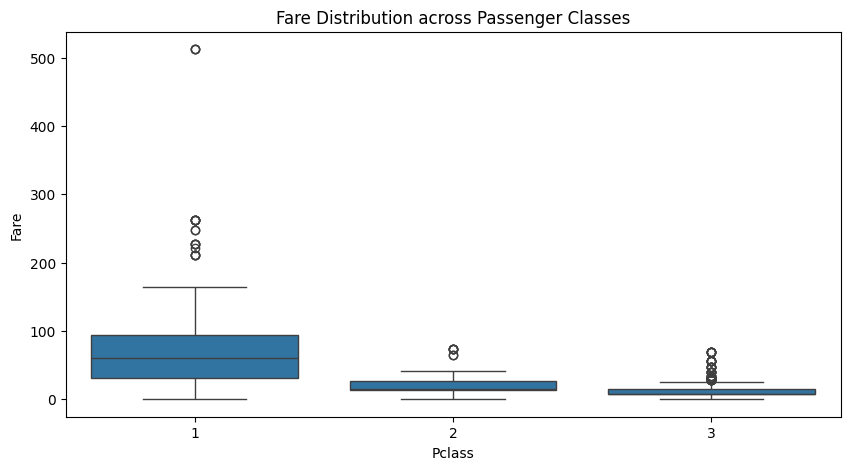

In [141]:
# Box plot for Fare and Pclass [cite: 5]
plt.figure(figsize=(10, 5))
sns.boxplot(x='Pclass', y='Fare', data=train_df)
plt.title('Fare Distribution across Passenger Classes')
plt.show()

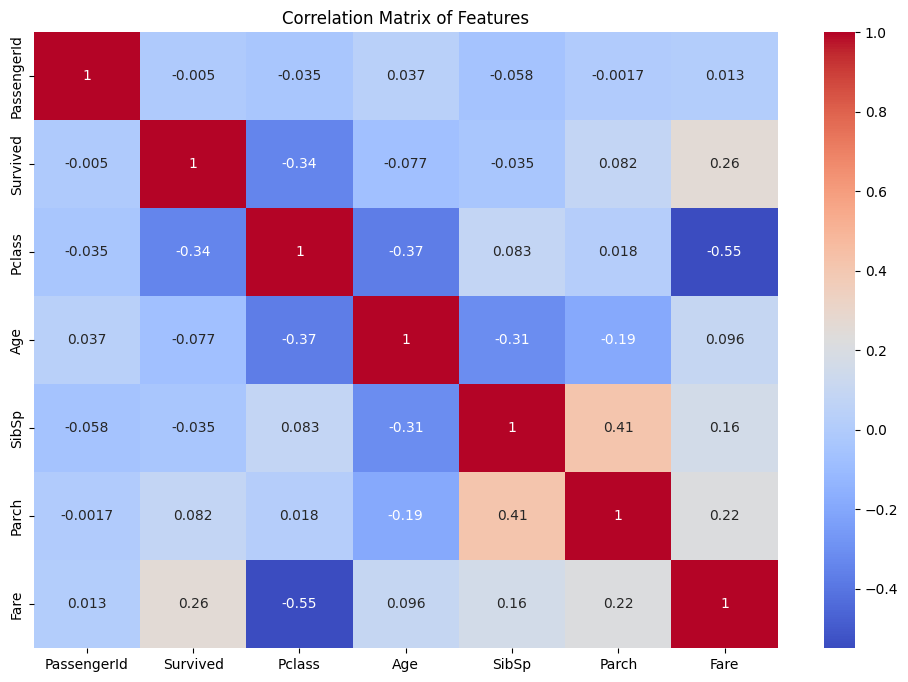

In [142]:
# Correlation Heatmap [cite: 6]
plt.figure(figsize=(12, 8))
sns.heatmap(train_df.select_dtypes(include=['number']).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()

In [143]:
def preprocess_data(df):
    # Handle missing values: Impute Age with median and Embarked with mode [cite: 8]
    df['Age'] = df['Age'].fillna(df['Age'].median())
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

    # Drop irrelevant features [cite: 4]
    df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

    # Encode categorical variables: Sex and Embarked [cite: 9]
    df = pd.get_dummies(df, columns=['Sex', 'Embarked'], drop_first=True)
    return df

In [144]:
# Apply preprocessing
# Reload the original datasets as they might have been modified in-place previously
train_df = pd.read_csv('Titanic_train.csv')
test_df = pd.read_csv('Titanic_test.csv')

train_cleaned = preprocess_data(train_df)
test_cleaned = preprocess_data(test_df)

In [145]:
# Align test columns with train columns (ensuring both have same encoded features)
X = train_cleaned.drop('Survived', axis=1)
y = train_cleaned['Survived']
X_test_final = test_cleaned # The test file doesn't have a 'Survived' column

print("Preprocessing complete. Train shape:", X.shape, "Test shape:", X_test_final.shape)

Preprocessing complete. Train shape: (891, 8) Test shape: (418, 8)


In [146]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pickle

In [147]:
# Split the original training data to evaluate locally before final test prediction [cite: 12]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [148]:
# Build and Train the model [cite: 11, 12]
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [149]:
# Save the model and feature names for Streamlit deployment [cite: 22]
with open('titanic_model.pkl', 'wb') as f:
    pickle.dump(log_model, f)
with open('features.pkl', 'wb') as f:
    pickle.dump(list(X.columns), f)

In [150]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

In [151]:
# Evaluate on validation set [cite: 14]
y_pred = log_model.predict(X_val)
y_prob = log_model.predict_proba(X_val)[:, 1]

print("--- Classification Report ---")
print(classification_report(y_val, y_pred))

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       105
           1       0.79      0.74      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



ROC-AUC Score: 0.8826


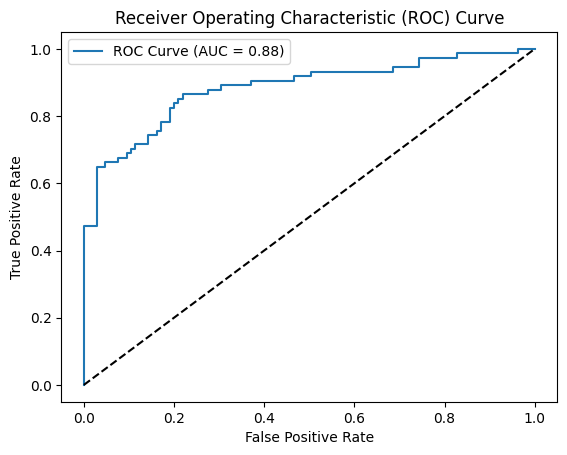

In [152]:
# ROC-AUC and Curve [cite: 14, 15]
auc_score = roc_auc_score(y_val, y_prob)
print(f"ROC-AUC Score: {auc_score:.4f}")

fpr, tpr, _ = roc_curve(y_val, y_prob)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [173]:
# Interpret coefficients [cite: 17]
coeff_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': log_model.coef_[0]})
coeff_df = coeff_df.sort_values(by='Coefficient', ascending=False)
print(coeff_df)

      Feature  Coefficient
4        Fare     0.002591
1         Age    -0.030537
3       Parch    -0.108108
6  Embarked_Q    -0.113105
2       SibSp    -0.295244
7  Embarked_S    -0.398065
0      Pclass    -0.936817
5    Sex_male    -2.591503


INSIGHTS
- Sex_male has a strongly negative coefficient, meaning being male significantly decreases survival probability.
- Pclass has a negative coefficient, implying higher class numbers (lower status) reduce survival chances.
- Fare has a positive coefficient, indicating higher-paying passengers had better survival odds.


In [198]:
!pip install streamlit

In [199]:
!npm install -g localtunnel -U

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧
changed 22 packages in 3s
⠧
⠧3 packages are looking for funding
⠧  run `npm fund` for details
⠧

In [200]:
%%writefile app.py
import streamlit as st
import pandas as pd
import pickle
import numpy as np

Overwriting app.py


In [201]:
# Load the trained model and features saved in previous steps
try:
    model = pickle.load(open('titanic_model.pkl', 'rb'))
    feature_names = pickle.load(open('features.pkl', 'rb'))
except FileNotFoundError:
    st.error("Model files not found. Please run the training cells first.")

st.set_page_config(page_title="Titanic Survival Predictor")
st.title("🚢 Titanic Survival Prediction")

2026-01-19 15:56:57.378 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-19 15:56:57.386 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-19 15:56:57.390 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-19 15:56:57.395 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

In [202]:
# User Inputs based on dataset features
st.sidebar.header("Passenger Details")
pclass = st.sidebar.selectbox("Travel Class (1 = 1st, 2 = 2nd, 3 = 3rd)", [1, 2, 3])
sex = st.sidebar.radio("Sex", ["female", "male"])
age = st.sidebar.slider("Age", 0, 80, 25)
sibsp = st.sidebar.number_input("Siblings/Spouses Aboard", 0, 8, 0)
parch = st.sidebar.number_input("Parents/Children Aboard", 0, 6, 0)
fare = st.sidebar.number_input("Fare Paid", 0.0, 512.0, 32.0)
embarked = st.sidebar.selectbox("Port of Embarkation", ["C", "Q", "S"])

2026-01-19 15:56:58.779 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-19 15:56:58.789 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-19 15:56:58.794 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-19 15:56:58.799 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-19 15:56:58.801 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-19 15:56:58.803 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-19 15:56:58.806 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-19 15:56:58.816 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [203]:
# Formatting input for the model
data = {
    'Pclass': pclass,
    'Age': age,
    'SibSp': sibsp,
    'Parch': parch,
    'Fare': fare,
    'Sex_male': 1 if sex == 'male' else 0,
    'Embarked_Q': 1 if embarked == 'Q' else 0,
    'Embarked_S': 1 if embarked == 'S' else 0
}

In [204]:
input_df = pd.DataFrame([data])

In [205]:
if st.button("Predict Survival"):
    prediction = model.predict(input_df)
    probability = model.predict_proba(input_df)[0][1]

    if prediction[0] == 1:
        st.success(f"The passenger is likely to survive! (Confidence: {probability:.2%})")
    else:
        st.error(f"The passenger is unlikely to survive. (Survival Probability: {probability:.2%})")

2026-01-19 15:57:01.876 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-19 15:57:01.882 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-19 15:57:01.890 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-19 15:57:01.893 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-19 15:57:01.901 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-19 15:57:01.905 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [1]:
# Run this cell to create the app.py file
app_code = """
import streamlit as st
import pandas as pd
import pickle

# Load model and features
model = pickle.load(open('titanic_model.pkl', 'rb'))
feature_names = pickle.load(open('features.pkl', 'rb'))

st.title("Titanic Survival Prediction App")
st.write("Enter passenger details to predict survival probability.")

# User Inputs [cite: 22]
pclass = st.selectbox("Passenger Class (1=1st, 2=2nd, 3=3rd)", [1, 2, 3])
age = st.slider("Age", 0, 100, 25)
sibsp = st.number_input("Siblings/Spouses Aboard", 0, 10, 0)
parch = st.number_input("Parents/Children Aboard", 0, 10, 0)
fare = st.number_input("Fare Paid", 0.0, 600.0, 32.0)
sex = st.selectbox("Sex", ["male", "female"])
embarked = st.selectbox("Port of Embarkation", ["S", "C", "Q"])

# Prepare input for prediction
data = {
    'Pclass': pclass, 'Age': age, 'SibSp': sibsp, 'Parch': parch, 'Fare': fare,
    'Sex_male': 1 if sex == 'male' else 0,
    'Embarked_Q': 1 if embarked == 'Q' else 0,
    'Embarked_S': 1 if embarked == 'S' else 0
}
input_df = pd.DataFrame([data])

if st.button("Predict"):
    prediction = model.predict(input_df)[0]
    prob = model.predict_proba(input_df)[0][1]

    if prediction == 1:
        st.success(f"Survived! (Probability: {prob:.2f})")
    else:
        st.error(f"Did Not Survive. (Probability of survival: {prob:.2f})")
"""

with open('app.py', 'w') as f:
    f.write(app_code)

print("app.py has been created. You can now deploy this to Streamlit Share or run it locally[cite: 21, 23].")

app.py has been created. You can now deploy this to Streamlit Share or run it locally[cite: 21, 23].


In [206]:
!wget -q -O - ipv4.icanhazip.com

34.148.11.175


In [207]:
!streamlit run app.py & npx localtunnel --port 8501

⠙⠹⠸⠼⠴⠦

⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸your url is: https://modern-games-kick.loca.lt

  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.148.11.175:8501

  Stopping...
^C
